**1. Install Libraries**

In [ ]:
!pip install nltk scikit-learn pandas streamlit matplotlib seaborn

**2. Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import zipfile
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**3. Load the Dataset**

In [ ]:
# Since the dataset is in zipfile so first extract it out in csv file
zip_path = "/content/IMDB Dataset.csv.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extracts in current directory

extracted_files = os.listdir()
print("Extracted files:", extracted_files)

Extracted files: ['.config', 'IMDB Dataset.csv', 'IMDB Dataset.csv.zip', 'sample_data']


In [ ]:
df = pd.read_csv("/content/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**4. Text Preprocessing**

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

df['clean_review'] = df['review'].apply(preprocess_text)

**5. Label Encoding**

In [ ]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
df.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...


**6. Vectorize Using TF-IDF**

In [ ]:
X = df['clean_review']
y = df['sentiment']

vectorizer = TfidfVectorizer(max_features=5000)
X_vect = vectorizer.fit_transform(X)

**7. Train-Test Splitting**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

**8. Train the SVM (LinearSVC) Model**

In [ ]:
model = LinearSVC()
model.fit(X_train, y_train)

LinearSVC()

**9. Model Evaluation**

In [ ]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8798
F1 Score: 0.8819717203456402
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



**10. Confusion Matrix**

In [ ]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

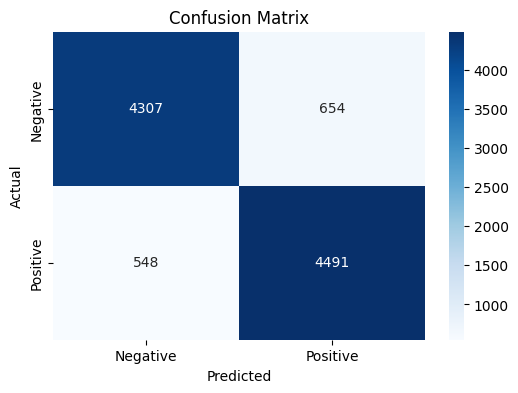

In [ ]:
# CM Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**11. ROC Curve & AUC**

In [ ]:
# Note: LinearSVC does not support predict_proba(), so we'll use decision_function instead
y_scores = model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

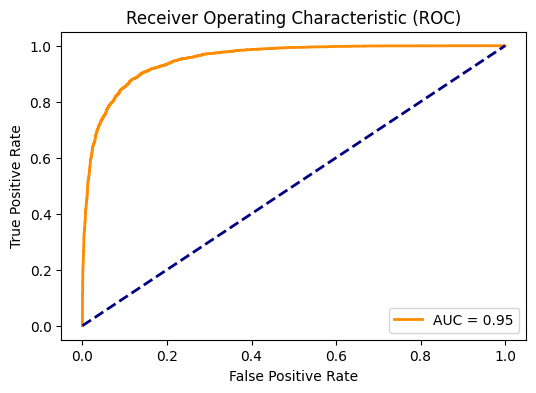

In [ ]:
# Plot ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**12. Save Model and Vectorizer as `.pkl`**

In [20]:
import pickle
# Save the trained model
with open('svm_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)

**13. `app.py` Code for Deployment**

In [21]:
import streamlit as st
import pickle
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Load trained model and vectorizer
with open('svm_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('vectorizer.pkl', 'rb') as vec_file:
    vectorizer = pickle.load(vec_file)

# Preprocessing function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    return text

# Streamlit UI
st.set_page_config(page_title="Movie Review Sentiment", page_icon="🎬")
st.title("🎬 Movie Review Sentiment Analyzer")
st.write("Enter a movie review and find out if it's **Positive** or **Negative**!")

# User input
review = st.text_area("📝 Type your movie review here:")

if st.button("Analyze Sentiment"):
    if review.strip() == "":
        st.warning("Please enter a review before submitting.")
    else:
        clean_review = preprocess(review)
        review_vector = vectorizer.transform([clean_review])
        prediction = model.predict(review_vector)

        if prediction[0] == 1:
            st.success("✅ Sentiment: **Positive** 🎉")
        else:
            st.error("❌ Sentiment: **Negative** 😢")

2025-04-13 11:44:57.990 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 11:44:57.992 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 11:44:58.316 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-13 11:44:58.317 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 11:44:58.319 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 11:44:58.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-13 11:44:58.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [22]:
!wget -qO- ipv4.icanhazip.com

34.85.137.113


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.85.137.113:8501

⠙⠹⠸⠼⠴Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇your url is: https://little-eyes-burn.loca.lt
